# Determining the Distribution given an input
## By Zain Nasrullah

The code below is derived from a combination of the following:
1) https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
2) http://www.aizac.info/simple-check-of-a-sample-against-80-distributions/

High-Level Steps
a) Fit the distribution
b) Find SSE to test the goodness of the fit
c) Track which distribution minimized SSE


# Find Distribution Function

In [16]:
# Import Statements
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Defining the function where the sample data will be passed in
def findDistribution (sample):
    
    # Create a distribution of the data which will be used to
    # calculate the sum of squared error. 
    y, x = np.histogram(sample, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    # These variables will maintain what the best fit is as we iterate
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    best_KS = st.norm
    best_D = np.inf
    
    # A list of the continuous probability distributions to test against
    cdfs = ['norm','uniform','logistic', 'chi2','beta','gamma']
    
    print("KS test results are:")
    
    # Iterate through each of the distributions
    for cdf in cdfs:
        
        # Use this line to disable the warnings when the data can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
        
            # fit our data set against every probability distribution
            parameters = eval("scipy.stats."+cdf+".fit(sample)");
            arg = parameters[:-2]
            loc = parameters[-2]
            scale = parameters[-1]

            # We will use our model parameters from the fit to find the probability density function
            pdf = eval("scipy.stats."+cdf+".pdf(x,loc=loc, scale = scale, *arg)")
            sse = np.sum(np.power(y - pdf, 2.0))

            # Apply the Kolmogorov-Smirnof one sided test
            D, p = scipy.stats.kstest(sample, cdf, args=parameters);

            # pretty-print the results, will not use this as part of algorithm but
            # rather for validation 
            print (cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"D: "+str(D));

            # compare current distribution against the past best distribution
            if best_sse > sse > 0:
                best_distribution = eval("st."+cdf)
                best_params = parameters
                best_sse = sse
            
            if best_D > D > 0:
                best_KS = cdf
                best_D = D
                  
    # return results when done
    return best_distribution.name, best_params, best_KS

# Testing with a Random Normal Sample

In [17]:
# Generate sample data from the normal distribution to work with
sample = scipy.stats.norm(0,1).rvs(500)
print("The actual distribution is norm\n")

# Run the algorithm and then print the results
best_dist_name, best_parameters, best_KS = findDistribution(sample)
print("The KS test found the best distribution as " + str(best_KS))
print("\nMinizing SSE found the best distribution as " + str(best_dist_name) + " with parameters " + str(best_parameters))

The actual distribution is norm

KS test results are:
norm            p: 0.695025349462        D: 0.0317389471938
uniform         p: 3.52162743411e-13     D: 0.170515881604
logistic        p: 0.72306692198         D: 0.03098616413
chi2            p: 0.0                   D: 0.609562844444
beta            p: 0.644796785819        D: 0.0333162701989
gamma           p: 0.608872008726        D: 0.0341575202992
The KS test found the best distribution as logistic

Minizing SSE found the best distribution as norm with parameters (-0.011170407085515683, 0.95738698668165312)


If you run the test above several times, one can observe that the result changes based on the random sample. In most cases, both the KS-test and minimizing the SSE fail to determine the correct distribution. More on this in the conclusion. 

# Plotting the Best-Fit PDF

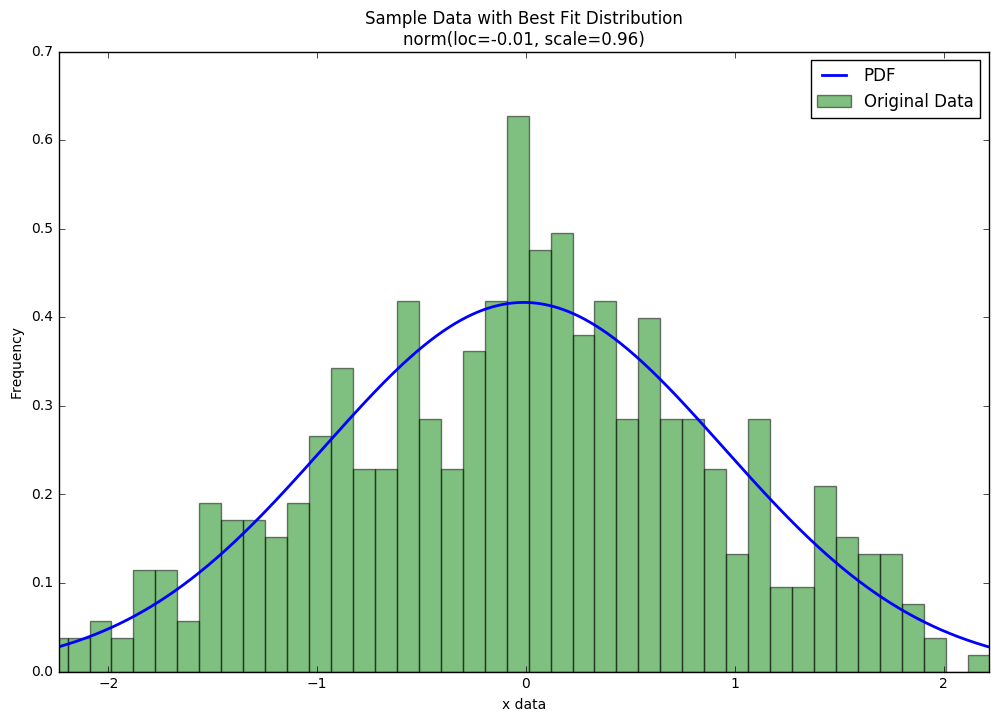

In [18]:
# Plotting the data below.
#The code in this cell is taken entirely from the Stack Overflow link. 
def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)
    
    return pdf, x

data = pd.DataFrame(sample)

# Find best fit distribution
best_dist = getattr(st, best_dist_name)

# Make PDF
pdf, rv = make_pdf(best_dist, best_parameters)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed = True, alpha=0.5, label='Data', legend=True, ax=ax)
ax.legend(["PDF", "Original Data"])

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_parameters)])
dist_str = '{}({})'.format(best_dist_name, param_str)

ax.set_title(u'Sample Data with Best Fit Distribution\n' + dist_str)
ax.set_xlabel(u'x data')
ax.set_ylabel('Frequency')
plt.show()

# Summary Statistics

In [22]:
# Summary Statistics for the original data
data.describe()

,0
count,500.000000
mean,-0.011170
std,0.958346
min,-2.616080
25%,-0.658856
50%,-0.004011
75%,0.610660
max,2.641511


In [23]:
# Summary statistics for the generated PDF with given parameters
stats_series = pd.DataFrame(rv)
stats_series.describe()

,0
count,10000.000000
mean,-0.011170
std,1.286076
min,-2.238386
25%,-1.124778
50%,-0.011170
75%,1.102437
max,2.216045


# Conclusion

From the stats above, it seems that the model is a fairly accurate representation of the data even if using the wrong probability distribution. This is because the process used to determine the correct model involved fitting and minimizing square error, so even a potentially incorrect model may possess the right parameters to describe the data. This is a bit concerning and an important reminder that one cannot simply point to a single distribution that fits the data; however, we can identify which distributions are poor fits. The summary statistics (mean, std, min, max), irrespective of whether the final model is correct, are also all within in a reasonable range of the actual data.

In terms of computational efficiency, since we are manually fitting and then testing each distribution (brute force) for minimal SSE, one cannot say that this is an efficient process. For large data-sets where we must test many distributions, this may not be a practical option. There should be some way, either during the iterations or as pre-processing work, to limit the scope of how many distributions we need to test. For example, if two distributions are similar, and one very poorly fit the data-- then it is likely that a similar model will also be a poor match.